In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.activations import linear, relu, sigmoid
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import math
import seaborn as sns

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import xgboost as xgb

%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('./deeplearning.mplstyle')

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

np.set_printoptions(precision=2)

#### Preprocessing of the data
#### First we drop the unused data, or NA values
#### Then we convert the genres into numerical values so it can be used by the machine learning algorithm


In [2]:
#load data, drop unnecessary columns, and drop all NA values
df = pd.read_csv('music_genre.csv')
df.info()
features = ['instance_id','popularity','acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','valence']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

#### The above features are proposed to do a first revision on the data, things like Artist name,  title and the obtained data are already left out, since they have no direct link to a specific genre. One could say that an artist would probably stick to a specific genre, but this knowledge is irrelevant to new artists, and would lead to overfitting. To check wether we should drop any other columns, we plot the distributions for all the remaining features for each specific genre using seaborn. In this step, key and mode are already one hot encoded, since they are categorical features

In [3]:
#load data, drop unnecessary columns, and drop all NA values
df = pd.read_csv('music_genre.csv')
df.info()

# Drop rows with NaN values across the dataset
df.dropna(inplace=True)

features = ['instance_id','popularity','acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','valence']
numeric_features = ['instance_id','popularity','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','valence']
categoric_features = ['key', 'mode']

encoder = OneHotEncoder()

mode_encoded = encoder.fit_transform(df[['mode']]).toarray()
mode_encoded_df = pd.DataFrame(mode_encoded, columns=encoder.get_feature_names_out(['mode']))
df = pd.concat([df, mode_encoded_df], axis=1)
df.drop(['mode'], axis=1, inplace=True)

key_encoded = encoder.fit_transform(df[['key']]).toarray()
key_encoded_df = pd.DataFrame(key_encoded, columns=encoder.get_feature_names_out(['key']))
df = pd.concat([df, key_encoded_df], axis=1)
df.drop(['key'], axis=1, inplace=True)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

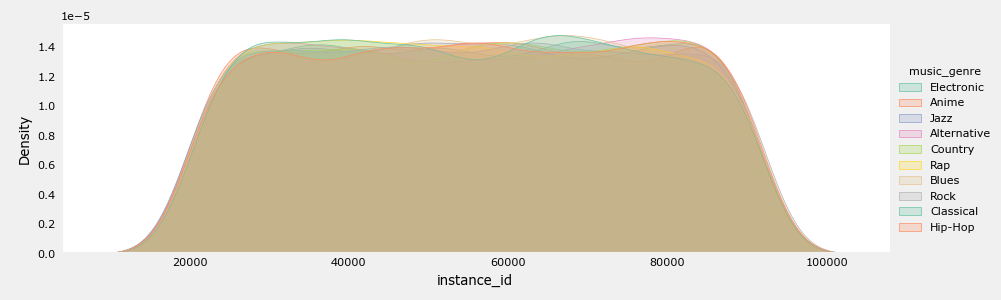

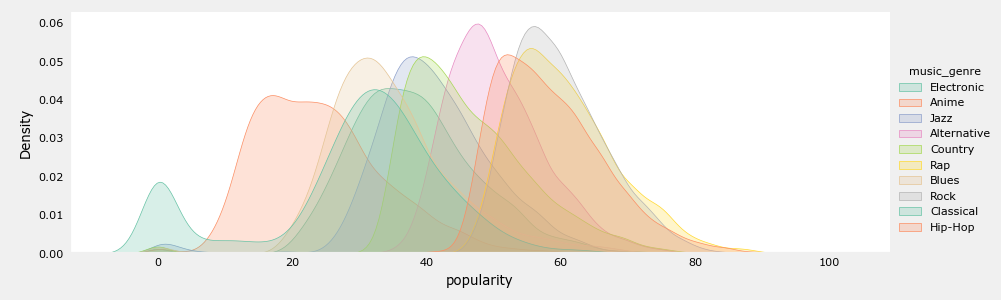

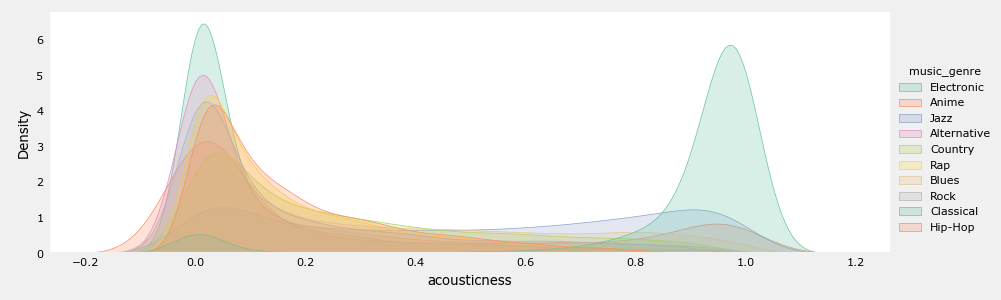

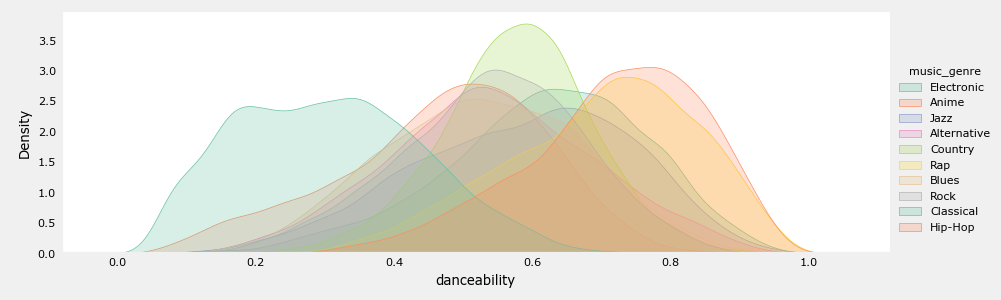

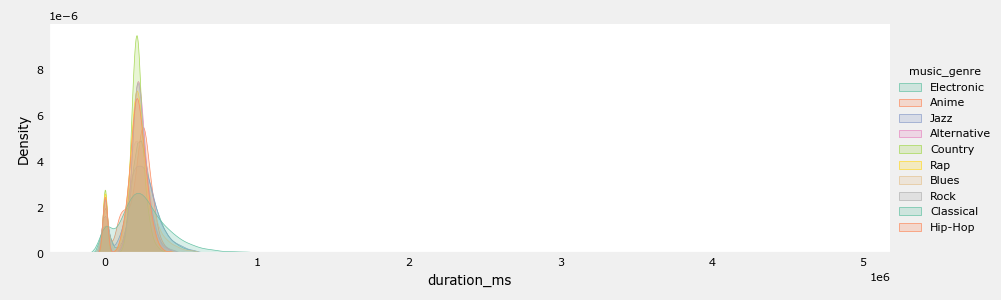

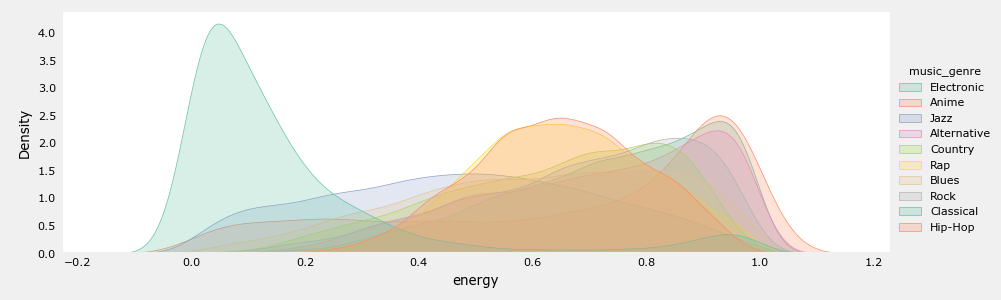

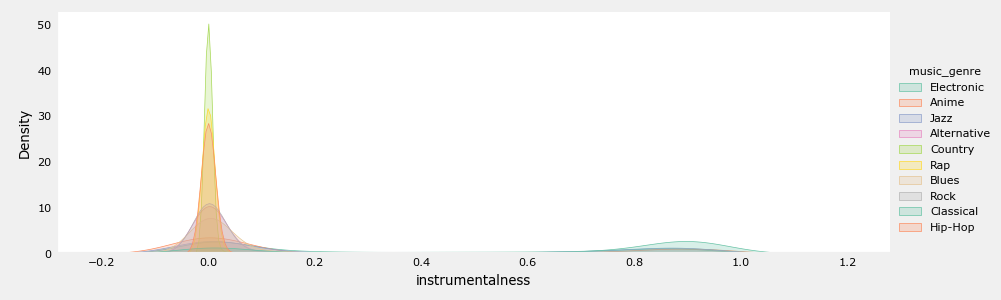

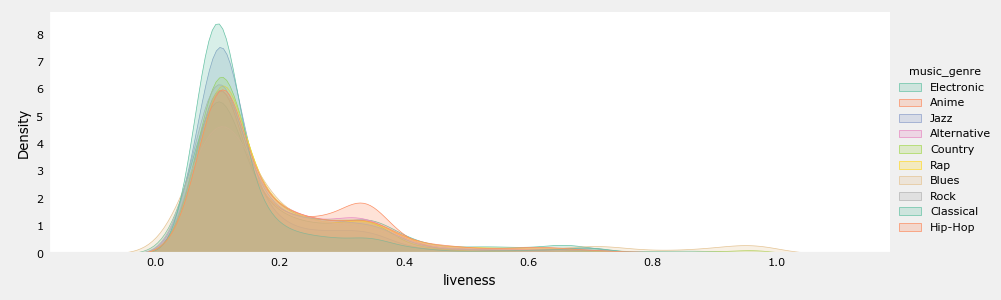

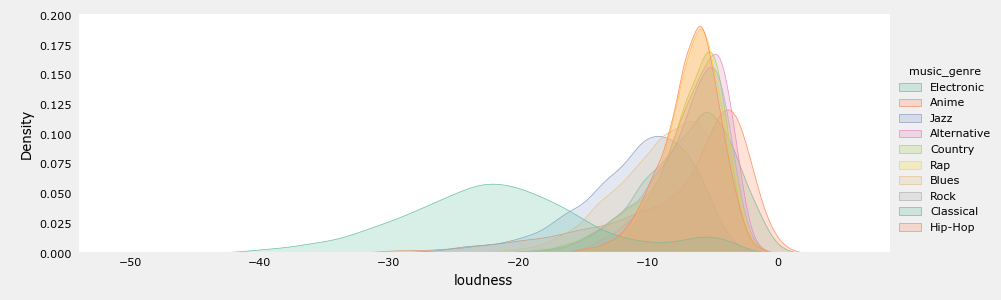

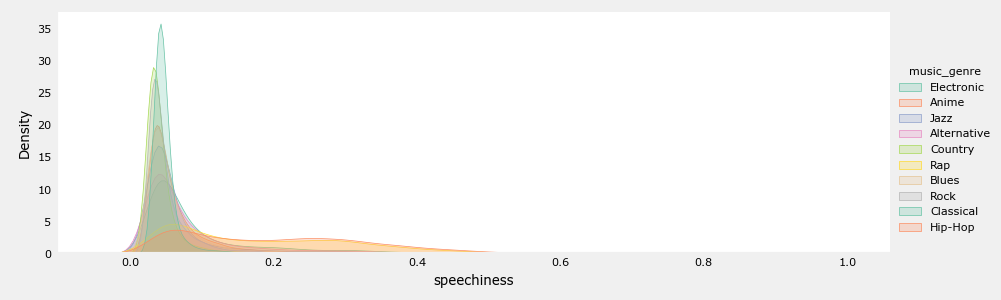

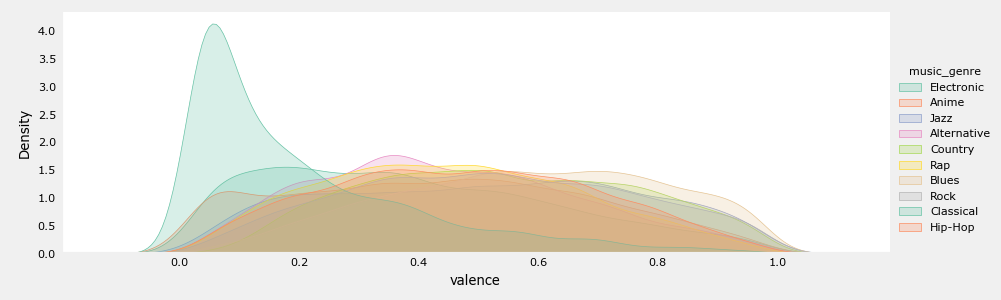

In [4]:
for feature in numeric_features:
    
    fig = sns.FacetGrid(df, hue="music_genre", aspect=3, palette="Set2") 
    fig.map(sns.kdeplot, feature, fill=True)
    fig.add_legend()

In [5]:
df = df.drop(['instance_id', 'artist_name', 'track_name','tempo', 'obtained_date', 'duration_ms','loudness'], axis=1) 
df = df.dropna()
df = df.sample(frac=1)

genre_encoder  = LabelEncoder()
df['music_genre'] = genre_encoder.fit_transform(df['music_genre'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49995 entries, 1501 to 3025
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        49995 non-null  float64
 1   acousticness      49995 non-null  float64
 2   danceability      49995 non-null  float64
 3   duration_ms       49995 non-null  float64
 4   energy            49995 non-null  float64
 5   instrumentalness  49995 non-null  float64
 6   liveness          49995 non-null  float64
 7   loudness          49995 non-null  float64
 8   speechiness       49995 non-null  float64
 9   valence           49995 non-null  float64
 10  music_genre       49995 non-null  int32  
 11  mode_Major        49995 non-null  float64
 12  mode_Minor        49995 non-null  float64
 13  key_A             49995 non-null  float64
 14  key_A#            49995 non-null  float64
 15  key_B             49995 non-null  float64
 16  key_C             49995 non-null  floa

In [6]:
X = df.drop('music_genre', axis=1)
Y = df['music_genre']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=777)
scaler = StandardScaler()
size = X_train.shape[1]

### Implementation of a Dense layered Neural network for multi class classification from the lab session, but adjusted to get the best solution for our case

In [7]:
model = Sequential(
    [
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax'), 
        
    ], name="Complex"
)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  
    metrics=['accuracy']
)


In [8]:
train = model.fit(X_train , Y_train , validation_data=(X_test,Y_test),epochs=100)

Epoch 1/100
1250/1250 [==============================] - 5s 3ms/step - loss: 268.0642 - accuracy: 0.1160 - val_loss: 2.2444 - val_accuracy: 0.1204
Epoch 2/100
1250/1250 [==============================] - 4s 3ms/step - loss: 2.3235 - accuracy: 0.1257 - val_loss: 2.2260 - val_accuracy: 0.1286
Epoch 3/100
1250/1250 [==============================] - 3s 3ms/step - loss: 2.6353 - accuracy: 0.1313 - val_loss: 2.2217 - val_accuracy: 0.1289
Epoch 4/100
1250/1250 [==============================] - 3s 3ms/step - loss: 2.2161 - accuracy: 0.1353 - val_loss: 2.2135 - val_accuracy: 0.1298
Epoch 5/100
1250/1250 [==============================] - 4s 3ms/step - loss: 2.2099 - accuracy: 0.1384 - val_loss: 2.2128 - val_accuracy: 0.1308
Epoch 6/100
1250/1250 [==============================] - 4s 3ms/step - loss: 2.2052 - accuracy: 0.1399 - val_loss: 2.2241 - val_accuracy: 0.1297
Epoch 7/100
1250/1250 [==============================] - 4s 3ms/step - loss: 2.2034 - accuracy: 0.1387 - val_loss: 2.2282 - val_

# Logistic Regression


Logistic regression can only be done for binary classification, to solve this, we can apply one hot encoding, this way we can use the regression to differ one genre from the others


In [10]:
df = pd.read_csv('music_genre.csv')
df.info()
df = df.dropna()

features = ['popularity','acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','valence']
numeric_features = ['popularity','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','valence']
categoric_features = ['key', 'mode']

encoder_mode = OneHotEncoder()
encoder_mode.fit(df[['mode']])
mode_encoded = encoder_mode.transform(df[['mode']]).toarray()
mode_encoded_df = pd.DataFrame(mode_encoded, columns=encoder_mode.get_feature_names_out(['mode']))
df = pd.concat([df, mode_encoded_df], axis=1)
df.drop(['mode'], axis=1, inplace=True)

# Fit and transform 'key'
encoder_key = OneHotEncoder()
encoder_key.fit(df[['key']])
key_encoded = encoder_key.transform(df[['key']]).toarray()
key_encoded_df = pd.DataFrame(key_encoded, columns=encoder_key.get_feature_names_out(['key']))
df = pd.concat([df, key_encoded_df], axis=1)
df.drop(['key'], axis=1, inplace=True)

# Fit and transform 'music_genre'
encoder_genre = OneHotEncoder()
encoder_genre.fit(df[['music_genre']])
genre_encoded = encoder_genre.transform(df[['music_genre']]).toarray()
genre_encoded_df = pd.DataFrame(genre_encoded, columns=encoder_genre.get_feature_names_out(['music_genre']))
df = pd.concat([df, genre_encoded_df], axis=1)
df.drop(['music_genre'], axis=1, inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

In [11]:
df = df.drop(['instance_id', 'artist_name', 'track_name','obtained_date','tempo'], axis=1) 

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50005 entries, 0 to 10004
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   popularity               50000 non-null  float64
 1   acousticness             50000 non-null  float64
 2   danceability             50000 non-null  float64
 3   duration_ms              50000 non-null  float64
 4   energy                   50000 non-null  float64
 5   instrumentalness         50000 non-null  float64
 6   liveness                 50000 non-null  float64
 7   loudness                 50000 non-null  float64
 8   speechiness              50000 non-null  float64
 9   valence                  50000 non-null  float64
 10  mode_Major               50000 non-null  float64
 11  mode_Minor               50000 non-null  float64
 12  key_A                    50005 non-null  float64
 13  key_A#                   50005 non-null  float64
 14  key_B                 

In [12]:

encoded_features = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',  'valence', 'mode_Major', 'mode_Minor', 'key_A', 'key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F', 'key_F#', 'key_G', 'key_G#', 'key_nan']
encoded_genres = ['music_genre_Alternative', 'music_genre_Anime', 'music_genre_Blues', 'music_genre_Classical', 'music_genre_Country', 'music_genre_Electronic', 'music_genre_Hip-Hop', 'music_genre_Jazz', 'music_genre_Rap', 'music_genre_Rock']




### In the following sections, the implementation of the logistic regression from the lab is implemented

Definition of the sigmoid function

In [13]:
# UNQ_C1
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
         
    """
          
    ### START CODE HERE ### 
    g = 1/(1+np.exp(-z))
    ### END SOLUTION ###  
    
    return g

It can also be interesting to discuss the compute cost for our model

In [14]:
# UNQ_C2
# GRADED FUNCTION: compute_cost
def compute_cost(X, y, w, b, lambda_= 1):
    """
    Computes the cost over all examples
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) target value 
      w : (array_like Shape (n,)) Values of parameters of the model      
      b : scalar Values of bias parameter of the model
      lambda_: unused placeholder
    Returns:
      total_cost: (scalar)         cost 
    """

    m, n = X.shape
    
    ### START CODE HERE ###
    zwb = w*X
    zwb = np.sum(zwb,axis=1)
    zwb += b
    fwb = sigmoid(zwb)
    cost = (-y*np.log(fwb))-(1-y)*np.log(1-fwb)
    total_cost= np.sum(cost)/m
    ### END CODE HERE ### 

    return total_cost


In [15]:
# UNQ_C3
# GRADED FUNCTION: compute_gradient
def compute_gradient(X, y, w, b, lambda_=None): 
    """
    Computes the gradient for logistic regression 
 
    Args:
      X : (ndarray Shape (m,n)) variable such as house size 
      y : (array_like Shape (m,1)) actual value 
      w : (array_like Shape (n,1)) values of parameters of the model      
      b : (scalar)                 value of parameter of the model 
      lambda_: unused placeholder.
    Returns
      dj_dw: (array_like Shape (n,1)) The gradient of the cost w.r.t. the parameters w. 
      dj_db: (scalar)                The gradient of the cost w.r.t. the parameter b. 
    """
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    ### START CODE HERE ### 
    zwb = w*X
    zwb = np.sum(zwb,axis=1)
    zwb += b
    fwb = sigmoid(zwb)
    dj_db = (np.sum(fwb-y))/m
    dj_dw = (np.dot((fwb-y), X))/m
    

    ### END CODE HERE ###

        
    return dj_db, dj_dw

In [16]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X :    (array_like Shape (m, n)
      y :    (array_like Shape (m,))
      w_in : (array_like Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)                 Initial value of parameter of the model
      cost_function:                  function to compute cost
      alpha : (float)                 Learning rate
      num_iters : (int)               number of iterations to run gradient descent
      lambda_ (scalar, float)         regularization constant
      
    Returns:
      w : (array_like Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

       
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

In [17]:
X = df[encoded_features]
Y = df[encoded_genres[5]]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=777)
m, n = X_train.shape
# Compute and display cost with w initialized to zeroes
initial_w = np.zeros(n)
initial_b = 0.
cost = compute_cost(X_train, Y_train, initial_w, initial_b)
print(cost)



# Some gradient descent settings
iterations = 10000
alpha = 0.001

w,b, J_history,_ = gradient_descent(X_train ,Y_train, initial_w, initial_b, 
                                   compute_cost, compute_gradient, alpha, iterations, 0)

0.6931471805599453


In [18]:
# UNQ_C4
# GRADED FUNCTION: predict

def predict(X, w, b): 
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w
    
    Args:
    X : (ndarray Shape (m, n))
    w : (array_like Shape (n,))      Parameters of the model
    b : (scalar, float)              Parameter of the model

    Returns:
    p: (ndarray (m,1))
        The predictions for X using a threshold at 0.5
    """
    # number of training examples
    m, n = X.shape   
    p = np.zeros(m)
    
    ### START CODE HERE ### 
    for i in range(m):   
         z_wb = 0
         for j in range(n): 
             #pandas doesn't support indexing for columns, so .iloc is needed
             z_wb_ij = X.iloc[i, j] * w[j]
             z_wb += z_wb_ij
      
         z_wb += b
         f_wb = sigmoid(z_wb)
         p[i] = f_wb >= 0.5
        
    ### END CODE HERE ### 
    return p


## this is first tested for rock songs, s

In [19]:
p = predict(X_train, w,b)
print('Train Accuracy for Rock: %f'%(np.mean(p == Y_train) * 100))


Train Accuracy for Rock: 89.968503


In [20]:
iterations = 3000

# For each genre
for genre in encoded_genres:
    # Set the target variable Y to be 1 for the current genre and 0 for all other genres
    Y = (df[genre] == 1).astype(int)
    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=777)

    # Initialize the weights and bias term
    m, n = X_train.shape
    initial_w = np.zeros(n)
    initial_b = 0.

    # Run gradient descent to learn the weights and bias term
    w, b, _, _ = gradient_descent(X_train, Y_train, initial_w, initial_b, compute_cost, compute_gradient, alpha, iterations, 0)
    p = predict(X_train, w,b)
    print('Train Accuracy for '+ genre+  '%f'%(np.mean(p == Y_train) * 100))
    p = predict(X_test, w,b)
    print('Test Accuracy for ' + genre +'%f'%(np.mean(p == Y_test) * 100))
    


Train Accuracy for music_genre_Alternative89.948505
Test Accuracy for music_genre_Alternative90.210979
Train Accuracy for music_genre_Anime89.968503
Test Accuracy for music_genre_Anime90.130987
Train Accuracy for music_genre_Blues89.988501
Test Accuracy for music_genre_Blues90.050995
Train Accuracy for music_genre_Classical89.958504
Test Accuracy for music_genre_Classical90.170983
Train Accuracy for music_genre_Country89.991001
Test Accuracy for music_genre_Country90.040996
Train Accuracy for music_genre_Electronic89.968503
Test Accuracy for music_genre_Electronic90.130987
Train Accuracy for music_genre_Hip-Hop90.015998
Test Accuracy for music_genre_Hip-Hop89.941006
Train Accuracy for music_genre_Jazz89.971003
Test Accuracy for music_genre_Jazz90.120988
Train Accuracy for music_genre_Rap90.055994
Test Accuracy for music_genre_Rap89.781022
Train Accuracy for music_genre_Rock90.143486
Test Accuracy for music_genre_Rock89.431057


With the one vs all approach, an accuracy of 90% can be obtained, for each individual genre, however, this doesn't compare multiple genres to each other. Below, the results for the built in one vs all code is also showed. The results are similar, but for the genre Rock, there is less accuracy.

In [21]:


# Initialize the one-vs-all classifier with logistic regression as the base classifier
clf = OneVsRestClassifier(LogisticRegression())
X = df[encoded_features].fillna(df[encoded_features].mean(axis=0))
Y = df[encoded_genres].fillna(df[encoded_genres].mean(axis=0))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=777)

# Fit the classifier to the training data
clf.fit(X_train, Y_train)

# Predict the classes for the training and test sets
p_train = clf.predict(X_train)
p_test = clf.predict(X_test)

# Compute the train and test accuracies
train_accuracy = np.mean(p_train == Y_train) * 100
test_accuracy = np.mean(p_test == Y_test) * 100

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Train Accuracy: music_genre_Alternative    89.948505
music_genre_Anime          89.018598
music_genre_Blues          89.988501
music_genre_Classical      93.223178
music_genre_Country        89.991001
music_genre_Electronic     89.968503
music_genre_Hip-Hop        82.154285
music_genre_Jazz           89.971003
music_genre_Rap            89.088591
music_genre_Rock           89.951005
dtype: float64
Test Accuracy: music_genre_Alternative    90.210979
music_genre_Anime          89.431057
music_genre_Blues          90.050995
music_genre_Classical      93.180682
music_genre_Country        90.040996
music_genre_Electronic     90.130987
music_genre_Hip-Hop        81.781822
music_genre_Jazz           90.120988
music_genre_Rap            88.911109
music_genre_Rock           89.121088
dtype: float64


d:\conda\envs\tf\lib\site-packages\numpy\core\fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
d:\conda\envs\tf\lib\site-packages\numpy\core\fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


# Other Techniques

## Random Forest

For the random forest, the data gets loaded again like in the neural network


In [4]:
#load data, drop unnecessary columns, and drop all NA values
df = pd.read_csv('music_genre.csv')
df.info()
features = ['instance_id','popularity','acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','valence']
#load data, drop unnecessary columns, and drop all NA values
df = pd.read_csv('music_genre.csv')
df.info()

# Drop rows with NaN values across the dataset
df.dropna(inplace=True)

features = ['instance_id','popularity','acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','valence']
numeric_features = ['instance_id','popularity','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','valence']
categoric_features = ['key', 'mode']

encoder = OneHotEncoder()

mode_encoded = encoder.fit_transform(df[['mode']]).toarray()
mode_encoded_df = pd.DataFrame(mode_encoded, columns=encoder.get_feature_names_out(['mode']))
df = pd.concat([df, mode_encoded_df], axis=1)
df.drop(['mode'], axis=1, inplace=True)

key_encoded = encoder.fit_transform(df[['key']]).toarray()
key_encoded_df = pd.DataFrame(key_encoded, columns=encoder.get_feature_names_out(['key']))
df = pd.concat([df, key_encoded_df], axis=1)
df.drop(['key'], axis=1, inplace=True)
df = df.drop(['instance_id', 'artist_name', 'track_name','tempo', 'obtained_date'], axis=1) 
df = df.dropna()
df = df.sample(frac=1)

X = df.drop('music_genre', axis=1)
Y = df['music_genre']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=77)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

In [23]:

#1000 estimators because we have a big dataset
randomForest = RandomForestClassifier(n_estimators=1000)


# Fit the classifier to the training data
randomForest.fit(X_train, Y_train)

# Predict the classes for the test set
Y_pred = randomForest.predict(X_test)
# Compute the test accuracy
test_accuracy = accuracy_score(Y_test, Y_pred) * 100

print(f'Test Accuracy: {test_accuracy}')
print(classification_report(Y_test, Y_pred))


Test Accuracy: 55.18551855185518
              precision    recall  f1-score   support

 Alternative       0.46      0.36      0.41       990
       Anime       0.76      0.75      0.76       981
       Blues       0.60      0.53      0.56      1013
   Classical       0.84      0.86      0.85      1005
     Country       0.56      0.61      0.59       945
  Electronic       0.65      0.62      0.63      1009
     Hip-Hop       0.34      0.38      0.36      1009
        Jazz       0.53      0.48      0.50      1007
         Rap       0.32      0.30      0.31      1040
        Rock       0.49      0.65      0.56      1000

    accuracy                           0.55      9999
   macro avg       0.55      0.55      0.55      9999
weighted avg       0.55      0.55      0.55      9999



We get a total accuracy of 55.5% This is already way better than the neural network can provide

## Grid Search

In [7]:
from sklearn.model_selection import GridSearchCV

# Define a set of parameters to test
param_grid = {
    'n_estimators': [100, 200,500,1000],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

clf = RandomForestClassifier()

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=4, verbose=2)
grid_search.fit(X_train, Y_train)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Predict and evaluate the model using the best found parameters
best_predictions = grid_search.predict(X_test)
print('Accuracy:', accuracy_score(Y_test, best_predictions))
print(classification_report(Y_test, best_predictions))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
Best cross-validation score: 0.5686068821102638
Accuracy: 0.5690569056905691
              precision    recall  f1-score   support

 Alternative       0.51      0.37      0.43      1006
       Anime       0.79      0.75      0.77       975
       Blues       0.63      0.56      0.60      1010
   Classical       0.85      0.84      0.84      1025
     Country       0.60      0.61      0.60      1009
  Electronic       0.64      0.62      0.63       984
     Hip-Hop       0.35      0.40      0.37       971
        Jazz       0.54      0.51      0.53      1020
         Rap       0.34      0.30      0.32      1006
        Rock       0.48      0.71      0.58       993

    accuracy                           0.57      9999
   macro avg       0.57      0.57      0.57      9999
weighted avg       0.57      0.57      0.57      9999

The GridSearch has a comparable result, however, we can see that the precision is more evened out, the bad scores are less bad, and the very good results are less good. So it is more evened out

# XGBoost

In [8]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
# Encode the target variable Y_train
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7]
}

# Create an XGBoost classifier
xgb_classifier = XGBClassifier()

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5)
grid_search.fit(X_train, Y_train_encoded)

# Get the best hyperparameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Fit the model on the training data using the best hyperparameters
xgb_classifier = XGBClassifier(**best_params)
xgb_classifier.fit(X_train, Y_train_encoded)

# Rest of the code...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

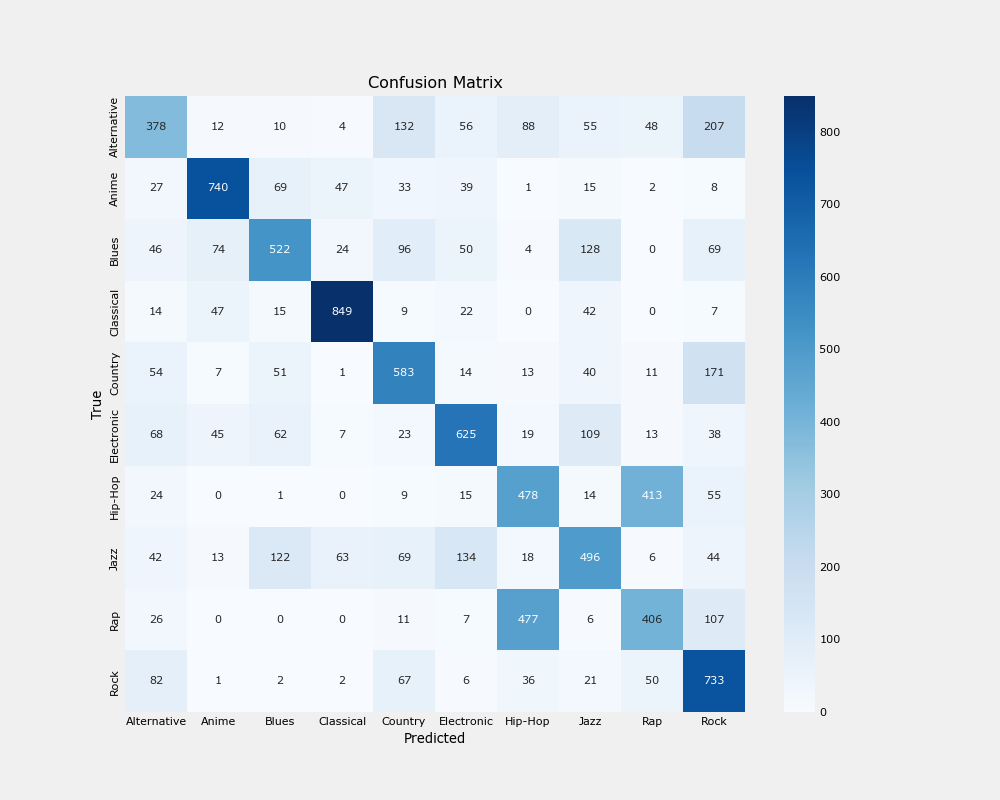

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(Y_test_encoded, predictions_encoded)

# Create a heat map of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


again, the result is slightly better and all results are more smooth. from the confusion matrix we can see that Rap and HipHop are often confused, which is quite logic, since the genres are very similar. In the next step, we take both genres together.

d:\conda\envs\tf\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Accuracy: 0.6712671267126713
              precision    recall  f1-score   support

 Alternative       0.50      0.38      0.43       990
       Anime       0.79      0.75      0.77       981
       Blues       0.61      0.52      0.56      1013
   Classical       0.85      0.85      0.85      1005
     Country       0.57      0.61      0.59       945
  Electronic       0.66      0.61      0.63      1009
     Hip-Hop       0.82      0.90      0.86      2049
        Jazz       0.54      0.49      0.51      1007
        Rock       0.52      0.69      0.59      1000

    accuracy                           0.67      9999
   macro avg       0.65      0.64      0.64      9999
weighted avg       0.67      0.67      0.67      9999



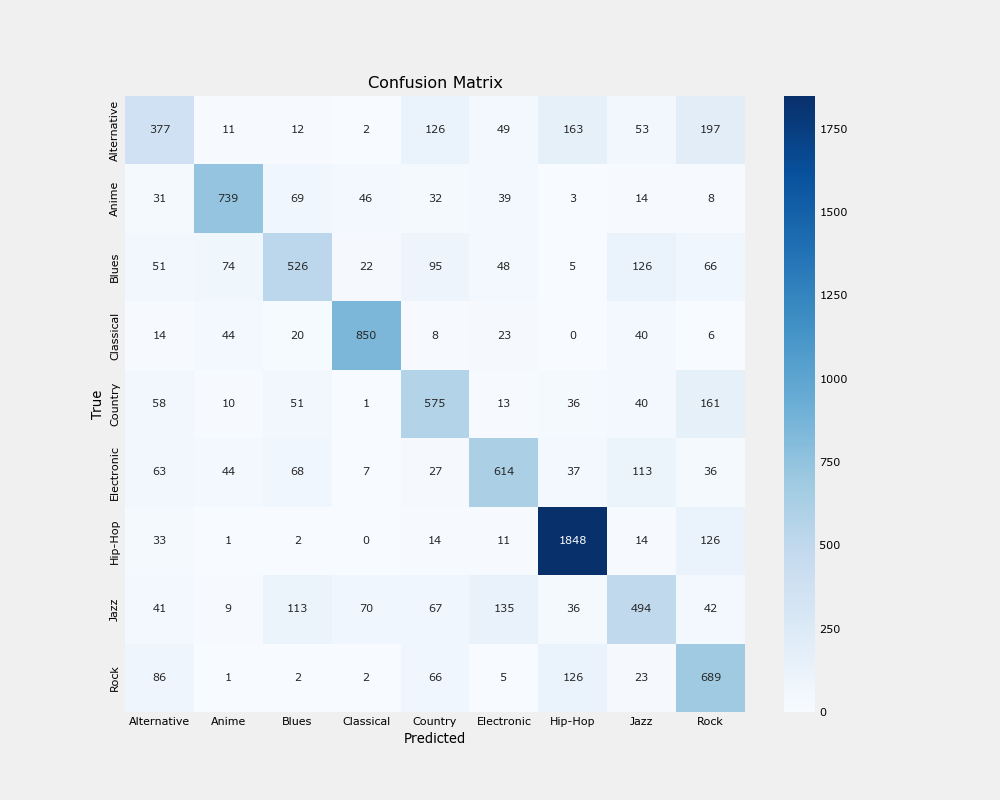

In [27]:
df['music_genre'] = df['music_genre'].replace('Rap', 'Hip-Hop')
X = df.drop('music_genre', axis=1)
Y = df['music_genre']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=77)

# Define the XGBoost classifier with some default parameters
xgb_classifier = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',  # For multiclass classification
    random_state=42
)

# Encode string class labels to integers
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)


# Fit the model on the encoded training data
xgb_classifier.fit(X_train, Y_train_encoded)

# Predict and evaluate the model on the encoded test data
predictions_encoded = xgb_classifier.predict(X_test)
predictions = label_encoder.inverse_transform(predictions_encoded)  # Decode the predictions back to original labels

# Predict and evaluate the model
predictions = xgb_classifier.predict(X_test)
print('Accuracy:', accuracy_score(Y_test_encoded, predictions_encoded))
print(classification_report(Y_test_encoded, predictions_encoded, target_names=label_encoder.classes_))

# Compute the confusion matrix
cm = confusion_matrix(Y_test_encoded, predictions_encoded)

# Create a heat map of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

As we can see, this improves the accuracy of the overall model by 10. However, it also skews the data to this.